### 1. Business Understanding

Problem Statement:  Prediction of Arrival Delay

Project Objective: (1) Regression Model (2) Model Deployment

### 2. Data Understanding

#### Data collection - ดึงไฟล์ 2008.csv จาก s3.amazonaws.com มาไว้ใน Linux File System

In [1]:
! wget https://s3.amazonaws.com/imcbucket/data/flights/2008.csv

--2018-10-13 12:48:03--  https://s3.amazonaws.com/imcbucket/data/flights/2008.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689413344 (657M) [binary/octet-stream]
Saving to: ‘2008.csv.2’

2008.csv.2          100%[=====================>] 657.48M  21.3MB/s   in 30s    

2018-10-13 12:48:34 (21.6 MB/s) - ‘2008.csv.2’ saved [689413344/689413344]



#### นับจำนวนบรรทัดในไฟล์ 2008.csv

In [2]:
! wc -l ./2008.csv

7009729 ./2008.csv


#### ดู Content ในไฟล์ 2008.csv

In [3]:
! head -3 2008.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,,0,NA,NA,NA,NA,NA
2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,,0,NA,NA,NA,NA,NA


#### ลบ Directory และไฟล์ 2008.csv ที่มีอยู่เดิมใน HDFS

In [4]:
! hdfs dfs -rm -f /user/cloudera/input/2008.csv

18/10/13 12:48:35 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Deleted /user/cloudera/input/2008.csv


#### สร้าง Directory "input" ใน HDFS

In [5]:
! hdfs dfs -mkdir -p /user/cloudera/input

18/10/13 12:48:38 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2


#### Copy ไฟล์ 2008.csv จาก Linux File System ไปไว้ใน Directory "input" ของ HDFS

In [6]:
! hadoop fs -put 2008.csv /user/cloudera/input

18/10/13 12:48:41 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2


#### แสดงและตรวจดูให้แน่ใจว่ามีไฟล์ 2008.csv อยู่ใน "input"

In [7]:
! hdfs dfs -ls /user/cloudera/input

18/10/13 12:48:45 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Found 1 items
-rw-r--r--   2 root hadoop  689413344 2018-10-13 12:48 /user/cloudera/input/2008.csv


#### Spark อ่านไฟล์ 2008.csv จาก HDFS มาเป็น DataFrame

In [8]:
airline_df = spark.read.format('csv').\
option('header','true').option('mode','DROPMALFORMED')\
.load('/user/cloudera/input/2008.csv')

#### Spark นับจำนวน tuple ใน DataFrame

In [9]:
airline_df.count()

7009728

#### Spark: Assign ค่าของตัวแปรเก่า ให้กับตัวแปรใหม่

In [10]:
airline_row_df = airline_df

#### Spark แสดง Schema ของข้อมูลใน DataFrame

In [11]:
airline_row_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

### 3. Data Preparation

#### Spark เรียกใช้ Data Types และ Functions ต่างๆ สำหรับจัดการข้อมูลใน DataFrame

In [12]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf

In [13]:
crunched_df = airline_row_df.\
withColumn('DepTime',airline_row_df['DepTime'].\
           cast(DoubleType())).\
withColumn('TaxiOut',airline_row_df['TaxiOut'].\
           cast(DoubleType())).\
withColumn('TaxiIn',airline_row_df['TaxiIn'].\
           cast(DoubleType())).\
withColumn('DepDelay',airline_row_df['DepDelay'].\
           cast(DoubleType())).\
withColumn('DayOfWeek',airline_row_df['DayOfWeek'].\
           cast(DoubleType())).\
withColumn('Distance',airline_row_df['Distance'].\
           cast(DoubleType())).\
withColumn('ArrDelay',airline_row_df['ArrDelay'].\
           cast(DoubleType()))

#### Spark แสดง Schema ของข้อมูลใน DataFrame หลังจาก cast type แล้ว

In [14]:
crunched_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

#### Python ติดตั้ง Module "pandas"

In [15]:
! pip install pandas

mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Spark ทำ Data Exploratory โดยใช้สถิติเบื้องต้นกับข้อมูลใน DataFrame

In [16]:
import pandas as pd
pd.DataFrame(crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().take(6),\
             columns=crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().columns).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DepTime,6873482,1333.8300461105448,478.0688948663011,1.0,2400.0
TaxiOut,6872670,16.453045177492882,11.332798654231896,0.0,429.0
TaxiIn,6858079,6.860851704974527,4.933649371300392,0.0,308.0
DayOfWeek,7009728,3.9241815088973495,1.9882589459851079,1.0,7.0
Distance,7009728,726.3870294253928,562.1018034840366,11.0,4962.0
ArrDelay,6855029,8.16845238729114,38.50193694882877,-519.0,2461.0


#### Spark ทำ Data Transformation โดยใช้ Data Discretization กับ "DepTime" ใน DataFrame

In [17]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [18]:
timeperiod = udf(lambda x: t_timeperiod(x),StringType())

In [19]:
discretized_df = crunched_df.\
withColumn('DepTime',timeperiod(crunched_df['DepTime']))

#### Spark ทำ Data Transformation โดยใช้ Data Normalization กับ "Distance" และ "ArrDelay" ใน DataFrame

In [20]:
from pyspark.sql.functions import *
max_distance = discretized_df.select(max('Distance')).collect()[0][0]
min_distance = discretized_df.select(min('Distance')).collect()[0][0]

In [21]:
max_ArrDelay = discretized_df.select(max('ArrDelay')).collect()[0][0]
min_ArrDelay = discretized_df.select(min('ArrDelay')).collect()[0][0]

In [22]:
def t_normalized_distance(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_distance)/(max_distance-min_distance))

In [23]:
def t_normalized_ArrDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_ArrDelay)/(max_ArrDelay-min_ArrDelay))

In [24]:
normalized_distance = udf(lambda x: t_normalized_distance(x),DoubleType())

In [25]:
normalized_ArrDelay = udf(lambda x: t_normalized_ArrDelay(x),DoubleType())

In [26]:
normalized_df = discretized_df.\
withColumn('Distance', normalized_distance(discretized_df['Distance'])).\
withColumn('ArrDelay', normalized_ArrDelay(discretized_df['ArrDelay']))

#### Spark ทำ Feature Selection ด้วยการเลือกเฉพาะบาง Attributes มาเป็น Features

In [27]:
features_df = normalized_df.\
select(['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay'])

#### Spark กำจัดค่า Null ด้วยการลบทั้ง Tuple (Record) เมื่อพบว่ามี Attribute ใดมีค่า Null

In [28]:
final_df = features_df.dropna()

#### Spark นับจำนวน tuple ใน DataFrame

In [29]:
final_df.count()

6855029

In [30]:
final_df.show()

+-------------+------+----+-----------+-------+------+--------+---------+--------------------+-------------------+
|UniqueCarrier|Origin|Dest|    DepTime|TaxiOut|TaxiIn|DepDelay|DayOfWeek|            Distance|           ArrDelay|
+-------------+------+----+-----------+-------+------+--------+---------+--------------------+-------------------+
|           WN|   IAD| TPA|18.00-24.00|    8.0|   4.0|     8.0|      4.0| 0.16138153908301353|0.16946308724832215|
|           WN|   IAD| TPA|06.00-11.59|   10.0|   5.0|    19.0|      4.0| 0.16138153908301353|0.17483221476510066|
|           WN|   IND| BWI|06.00-11.59|   17.0|   3.0|     8.0|      4.0|  0.1017976166431024|0.17885906040268457|
|           WN|   IND| BWI|06.00-11.59|    7.0|   3.0|    -4.0|      4.0|  0.1017976166431024|0.17214765100671142|
|           WN|   IND| BWI|18.00-24.00|   10.0|   3.0|    34.0|      4.0|  0.1017976166431024| 0.1855704697986577|
|           WN|   IND| JAX|18.00-24.00|   10.0|   4.0|    25.0|      4.0|  0.136

### 4. Modeling (and making some data transformation )

#### Spark แบ่งข้อมูลเป็น training set และ test set

In [31]:
training_df,test_df = final_df.\
randomSplit([0.80,0.20], seed = 12)

#### Spark นับจำนวน tuple ใน DataFrame

In [32]:
training_df.count()

5482630

#### Spark แสดง Schema ของ training set

In [33]:
training_df.printSchema()

root
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrDelay: double (nullable = true)



#### Transformation categorical variable to numerical one.

In [34]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder

In [35]:
DepTimeIndexer = StringIndexer\
(inputCol='DepTime',outputCol='DepTimeIndexed')

In [36]:
DepTimeOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DepTimeIndexed', \
 outputCol='DepTimeVec')

In [37]:
UniqueCarrierIndexer = StringIndexer\
(inputCol='UniqueCarrier',\
 outputCol='UniqueCarrierIndexed')

In [38]:
UniqueCarrierOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='UniqueCarrierIndexed',\
 outputCol='UniquecarrierVec')

In [39]:
OriginIndexer = StringIndexer(inputCol='Origin',\
                              outputCol='OriginIndexed')

In [40]:
OriginOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='OriginIndexed',\
 outputCol='OriginVec')

In [41]:
DestIndexer = StringIndexer(inputCol='Dest',\
                            outputCol='DestIndexed')

In [42]:
DestOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DestIndexed',\
 outputCol='DestVec')

In [43]:
#labelIndexer = StringIndexer(inputCol='ArrDelay',outputCol='labelIndexed')

#### Combines a selected columns into a single vector column.

In [44]:
from pyspark.mllib.linalg import Vectors

In [45]:
from pyspark.ml.feature import VectorAssembler

In [46]:
from pyspark.ml import Pipeline

In [47]:
featureAssembler = VectorAssembler\
(inputCols=['UniqueCarrierIndexed',\
            'OriginVec',\
            #'DestVec',\
            'DepTimeVec',\
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ], outputCol='***features')

#### Define an algorithm.

In [48]:
from pyspark.ml.regression import RandomForestRegressor

In [49]:
dt = RandomForestRegressor\
(labelCol='ArrDelay',featuresCol='***features')

#### Pipeline.

In [50]:
pipeline_dt = Pipeline().\
setStages([UniqueCarrierIndexer,\
           UniqueCarrierOneHotEncoder,\
           DepTimeIndexer,\
           DepTimeOneHotEncoder,\
           OriginIndexer ,\
           OriginOneHotEncoder,\
           DestIndexer,\
           DestOneHotEncoder,\
           featureAssembler,dt])

In [51]:
#training_df.count()

#### Launch the pipeline and get a model.

In [52]:
dtModel = pipeline_dt.fit(training_df)

#### print out model structure

In [53]:
tree = dtModel.stages[9]

In [54]:
tree.toDebugString

'RandomForestRegressionModel (uid=RandomForestRegressor_4134b63d2275ae3608e2) with 20 trees\n  Tree 0 (weight 1.0):\n    If (feature 309 <= 59.0)\n     If (feature 0 in {0.0,2.0,4.0,12.0,14.0,16.0,18.0,19.0})\n      If (feature 309 <= 14.0)\n       If (feature 39 in {0.0})\n        If (feature 311 <= 0.1276509796000808)\n         Predict: 0.17272299608027053\n        Else (feature 311 > 0.1276509796000808)\n         Predict: 0.17216944237898643\n       Else (feature 39 not in {0.0})\n        If (feature 311 <= 0.04302161179559685)\n         Predict: 0.1732040503829081\n        Else (feature 311 > 0.04302161179559685)\n         Predict: 0.17508380787743202\n      Else (feature 309 > 14.0)\n       If (feature 0 in {0.0,4.0,16.0,19.0})\n        If (feature 307 <= 34.0)\n         Predict: 0.18248294916442623\n        Else (feature 307 > 34.0)\n         Predict: 0.19456270009904805\n       Else (feature 0 not in {0.0,4.0,16.0,19.0})\n        If (feature 308 <= 16.0)\n         Predict: 0.184

### 5. Evaluation

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null

In [55]:
result_df = dtModel.transform(test_df.dropna())

#### แสดงผลลัพธ์เปรียบเทียบระหว่าง Arrival Delay จริง กับ Prediction of Arrival Delay

In [56]:
result_df.select(['ArrDelay','Prediction']).show()

+-------------------+-------------------+
|           ArrDelay|         Prediction|
+-------------------+-------------------+
| 0.1644295302013423|0.17239341950842427|
|0.17718120805369128|0.17508616174218433|
|0.18053691275167785|0.17550853889513396|
|0.20536912751677852| 0.2005353986963721|
| 0.1761744966442953| 0.1734195841518387|
|0.17885906040268457|   0.17376119642618|
|0.18053691275167785|0.18073241665422352|
|0.16778523489932887|0.17279448915942427|
|  0.174496644295302|0.17405270984681262|
|0.16946308724832215|0.17279448915942427|
|0.16946308724832215|0.17326128428135162|
|0.17718120805369128| 0.1827435645448029|
|0.17583892617449665|0.18007876934004308|
|0.16644295302013423|0.17279448915942427|
|0.18825503355704698|0.18043422451104046|
| 0.1738255033557047|0.17467737777416575|
|0.17181208053691274|0.17279448915942427|
| 0.1714765100671141|0.17279448915942427|
|0.17751677852348993|0.17488506907497267|
|0.17651006711409395|0.17279448915942427|
+-------------------+-------------

#### Plot a Graph

In [57]:
! pip install pandas

mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [58]:
#sample for 7000 row from 1361937 millions
lr_prediction_sample = result_df.select("prediction","ArrDelay")
lr_prediction_sample1 = lr_prediction_sample.limit(3500)
lr_prediction_sample2 = lr_prediction_sample1.sort("ArrDelay", ascending=True)
#convert to pandas
lr_prediction_sample_pd = lr_prediction_sample1.toPandas()

In [59]:
print(lr_prediction_sample_pd.info())
lr_prediction_sample_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
prediction    3500 non-null float64
ArrDelay      3500 non-null float64
dtypes: float64(2)
memory usage: 54.8 KB
None


,prediction,ArrDelay
0,0.172393,0.164430
1,0.175086,0.177181
2,0.175509,0.180537
3,0.200535,0.205369
4,0.173420,0.176174


In [60]:
lr_prediction_sample_pd['id'] = lr_prediction_sample_pd.index

In [61]:
! pip install seaborn

mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [62]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

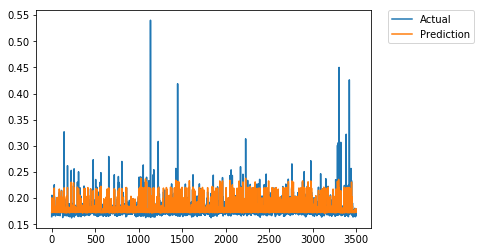

In [63]:
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['ArrDelay'],label='Actual')
#plt.plot(cv_prediction_sample_pd['id'] , cv_prediction_sample_pd['prediction'],label='CV_Prediction')
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['prediction'],label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()

In [64]:
training_df.count()

5482630

#### กรองบาง Tuples (Records) ทิ้งไปจาก testing set

In [65]:
from pyspark.ml.evaluation import RegressionEvaluator

In [66]:
new_test_df1 = test_df.filter(test_df.Origin != 'TUP')\
.filter(test_df.Origin != 'PIR')\
.filter(test_df.Dest != 'TUP')\
.filter(test_df.Dest != 'PIR')\
.filter(test_df.Origin != 'PUB')\
.filter(test_df.DepTime != '425')\
.filter(test_df.DepTime != '328')\
.filter(test_df.DepTime != '437')\
.filter(test_df.DepTime != '400')\
.filter(test_df.DepTime != '414')\
.filter(test_df.DepTime != '424')\
.filter(test_df.DepTime != '439')\
.filter(test_df.DepTime != '338')\
.filter(test_df.DepTime != '359')\
.filter(test_df.DepTime != '412')\
.filter(test_df.DepTime != '430')

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null และผ่านการกรองฯ แล้ว

In [67]:
everesult_df = dtModel.transform(new_test_df1.dropna())

In [68]:
lr_evaluator_r2 = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" \
      % lr_evaluator_r2.evaluate(everesult_df))

R Squared (R2) on test data = 0.735446


In [69]:
lr_evaluator_rmse = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" \
      % lr_evaluator_rmse.evaluate(everesult_df))

Root Mean Squared Error (RMSE) on test data = 0.0066312
